In [1]:
import os
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, losses
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow import keras
import cv2
import pandas as pd
from shutil import copyfile
from random import randint
import matplotlib.image as mpimg
import pandas as pd

In [2]:
src_dir  = "../input/trafficsign/"
train_dir = "/kaggle/input/trafficsign/Train"
test_dir = "./Dataset/Test/"

height = 30
width = 30
channels = 3
batchSize=32

In [3]:
# Load Tests And Validations
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(height,width),
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(height,width),
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [4]:
# Crate Model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(height,width,channels)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2700)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               691456    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 43)                5547      
Total params: 729,899
Trainable params: 729,899
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
# Train Model
history = model.fit(train_generator,epochs=10, validation_data=val_generator, batch_size=batchSize)

Epoch 1/10
981/981 [==============================] - 155s 158ms/step - loss: 2.4827 - accuracy: 0.3595 - val_loss: 1.3338 - val_accuracy: 0.6574
Epoch 2/10
981/981 [==============================] - 43s 43ms/step - loss: 0.8381 - accuracy: 0.7660 - val_loss: 0.9020 - val_accuracy: 0.7665
Epoch 3/10
981/981 [==============================] - 42s 43ms/step - loss: 0.5551 - accuracy: 0.8507 - val_loss: 0.9240 - val_accuracy: 0.7693
Epoch 4/10
981/981 [==============================] - 43s 44ms/step - loss: 0.4419 - accuracy: 0.8795 - val_loss: 0.9030 - val_accuracy: 0.7919
Epoch 5/10
981/981 [==============================] - 42s 43ms/step - loss: 0.3655 - accuracy: 0.9030 - val_loss: 1.1124 - val_accuracy: 0.7368
Epoch 6/10
981/981 [==============================] - 49s 50ms/step - loss: 0.3388 - accuracy: 0.9080 - val_loss: 1.0677 - val_accuracy: 0.7620
Epoch 7/10
981/981 [==============================] - 41s 41ms/step - loss: 0.3015 - accuracy: 0.9171 - val_loss: 1.0666 - val_accurac

In [7]:
# Load Test.csv And Copy Image base ClassId folders in new folders
df = pd.read_csv('../input/trafficsign/Test.csv')
!mkdir -p Dataset/Test

for i in tqdm(range(len(df))):
    if not os.path.exists(test_dir+str(df.iloc[i].ClassId)):
        os.makedirs(test_dir+str(df.iloc[i].ClassId))
    copyfile(src_dir+df.iloc[i].Path, test_dir+str(df.iloc[i].ClassId)+'/'+df.iloc[i].Path[5:])

100%|██████████| 12630/12630 [01:13<00:00, 172.76it/s]


In [8]:
# Load test Images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height,width),
    batch_size=batchSize,
    color_mode='rgb',    
    shuffle = False,
    seed=42,
    class_mode='categorical')

Found 12630 images belonging to 43 classes.


In [9]:
# predict Images
predict = model.predict(test_generator)
preds_classes = np.argmax(predict, axis=-1)

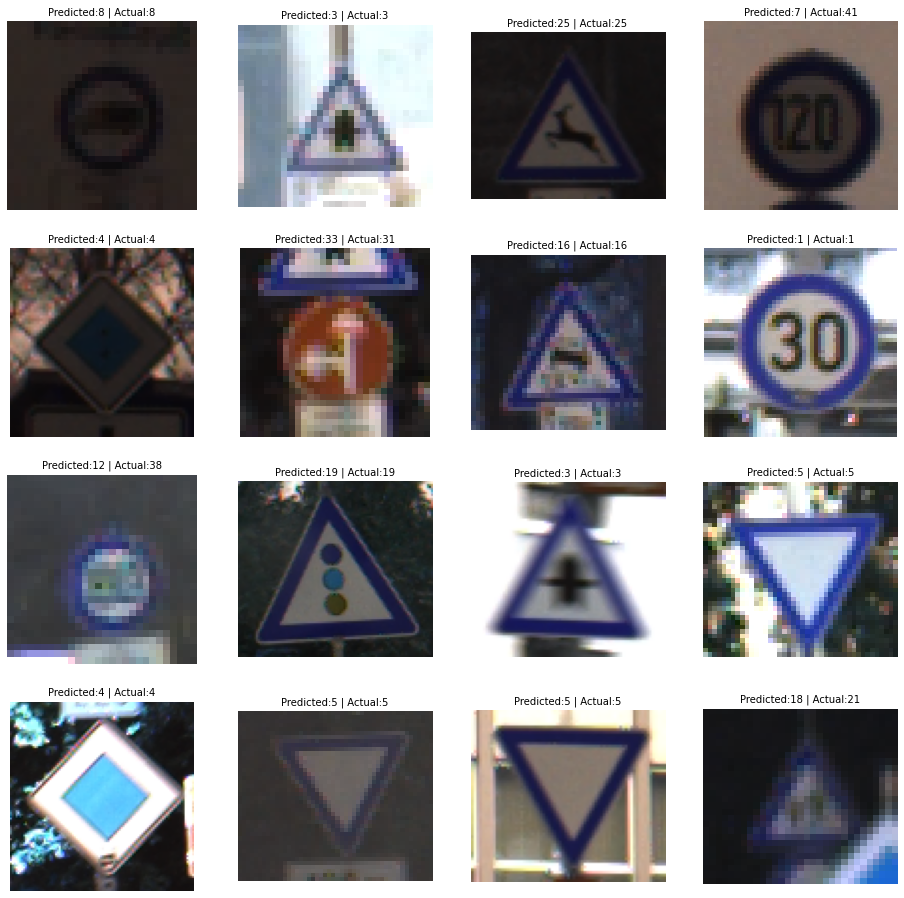

In [10]:
# Show images and labels and predicts
ncols=4
nrows=4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i in range(16):
    
    random=randint(0, len(test_generator.labels))
    prediction=preds_classes[random]
    img_path=test_generator.filepaths[random]
    
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    sp.set_title(f'Predicted:{prediction} | Actual:{test_generator.labels[random]}' ,fontsize=10)
    
    plt.imshow(cv2.cvtColor(mpimg.imread(img_path), cv2.COLOR_BGR2RGB))
    
plt.show()

In [11]:
# Save Model
model.save('Dense.h5')